## Handwritten Digits Classifier with Neural Networks

   This project was originally going to be done as a part of [Deep Learning Fundamentals](https://app.dataquest.io/course/deep-learning-fundamentals) class on DataQuest but the [dataset from UCI ML repository](https://archive.ics.uci.edu/ml/datasets/Optical+Recognition+of+Handwritten+Digits) and the implementation requirements were not challenging enough, so I modified the dataset and methodology.
   
* **Concepts learned:** Scikit-learn library in Python and Neural Network optimization schemes
* **Main challenges:** Performance changes with respect to the size of the data, Run-time challenges of the grid-search algorithm

The aim of this project is to classify handwritten digits in the [MNIST dataset](http://yann.lecun.com/exdb/mnist/) correctly using feedforward neural networks. The data is composed of 28x28 images in gray scale with pixel values ranging from 0 to 255.For sake of simplicity, the data is retrieved from [Kaggle website](https://www.kaggle.com/c/digit-recognizer/data).


## Data Exploration
Let us familiarize ourselves with the content of the data first. 

In [1]:
from sklearn.datasets import load_digits
import pandas as pd, numpy as np
from IPython.display import display
import matplotlib.pyplot as plt 
%matplotlib inline

from sklearn import preprocessing
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import ShuffleSplit,cross_validate,GridSearchCV
from sklearn.pipeline import make_pipeline,Pipeline


In [2]:
whole_set = pd.read_csv('train_mnist.csv')
display(print("Shape of the MNIST data:",whole_set.shape))
whole_set.head(5)

Shape of the MNIST data: (42000, 785)


None

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Each image is flattened out in rows and has an associated label to it at the first column. There seems to be 42000 entries in the dataset. Let us seperate the label and data in this dataframe: 

In [3]:
label= whole_set["label"]
print("Labels","Counts")
label.value_counts(sort=False)

Labels Counts


0    4132
1    4684
2    4177
3    4351
4    4072
5    3795
6    4137
7    4401
8    4063
9    4188
Name: label, dtype: int64

We have a dataset (relatively) uniformly distributed over the classes of interest and the pixel data looks like:

In [4]:
data = whole_set.iloc[:,1:]
data.head(5)

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Let us check what the images look like:

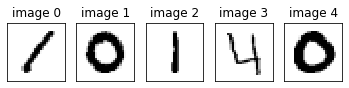

In [5]:
indices = np.arange(0,5)
fig, ax = plt.subplots(1,len(indices))

for i in indices:
    pic = np.array(data.iloc[i]).reshape(28,28)
    ax[i].tick_params(bottom=False,left=False,
                      labelbottom=False,labelleft=False) 
    ax[i].imshow(pic, cmap="gray_r")
    ax[i].set_title("image "+str(i))
    
plt.show()

## Model Setup

It is time to set aside a piece of our data to check our final model on after we are done with optimizing it.

In [6]:
from sklearn.model_selection import train_test_split

cv_data, held_out_data, cv_label, held_out_label = train_test_split(data,label,test_size = 0.2,random_state=42)
print("Shape of the data for cross-validation: ",cv_data.shape)
print("Shape of the held-out data: ",held_out_data.shape)


Shape of the data for cross-validation:  (33600, 784)
Shape of the held-out data:  (8400, 784)


Now, let us create the model and write down the helper functions to read the results:

In [7]:
def cv_pipe (nn_struc,data, label,n_fold):

    mlpc_pipe =MLPClassifier(hidden_layer_sizes = nn_struc,
                            activation = 'relu',
                            solver = 'adam'
                            #,max_iter = 1e3
                           )
    cv_type_pipe = ShuffleSplit(n_splits=n_fold, test_size=0.25, random_state=42)

    std_scaler = preprocessing.StandardScaler()

    pl = make_pipeline(std_scaler,mlpc_pipe)
    scores  = cross_validate(pl, 
                             data, label, 
                             cv = cv_type_pipe, 
                             return_train_score = True
                           )
    return scores

def read_scores(score_dict):
    for key in score_dict.keys():
        print(key,'\t',score_dict[key])
        
def train_vs_test_scores(n_node, score_dict):
    print("%i \t %.4f \t %.4f \t %.4f \t %.4f \t %.2f" 
      %(n_node, 
        score_dict["test_score"].mean(),score_dict["test_score"].std(),
        score_dict["train_score"].mean(),score_dict["train_score"].std(),
        score_dict["fit_time"].mean()
       )         
     )

**Lesson learned:** As you can see, the model is created in a pipeline and is following a pre-procesing step of standardization. When I initially attempted creating the model I naively fed the data into the neural network only to see it was taking forever to converge. This was mainly because the initial dataset I used was small and the images were compressed. Once the MNIST data is scaled, the model fit significantly fast and hence I created a pipeline for the cross-validation. Of course, this is a very simple way of preprocessing images but for now, I'll stick with it.

## Hyper Parameter Tuning

As the next step I will try to manually optimize a one-layer neural network and see how the network is doing before we dive into the grid-search based hyper parameter optimization.

In [8]:
print ("n_node \t test_avg \t test_sigma \t train_avg \t train_sigma \t fit_time_avg(s)")

train_scores_all = []
test_scores_all  = []
train_fit_times  = []

n_nodes = np.arange(15,41,5)

for n_node in n_nodes:
    score_n = cv_pipe ((n_node,),cv_data, cv_label,3)
    train_scores_all.append(score_n["train_score"])
    test_scores_all.append(score_n["test_score"])
    train_fit_times.append(score_n["fit_time"])
    train_vs_test_scores(n_node, score_n)


n_node 	 test_avg 	 test_sigma 	 train_avg 	 train_sigma 	 fit_time_avg(s)
15 	 0.9184 	 0.0049 	 0.9999 	 0.0001 	 73.20
20 	 0.9371 	 0.0005 	 1.0000 	 0.0000 	 42.28
25 	 0.9450 	 0.0012 	 0.9974 	 0.0036 	 36.22
30 	 0.9501 	 0.0010 	 1.0000 	 0.0000 	 33.32
35 	 0.9526 	 0.0010 	 1.0000 	 0.0000 	 33.51
40 	 0.9555 	 0.0013 	 1.0000 	 0.0000 	 30.05


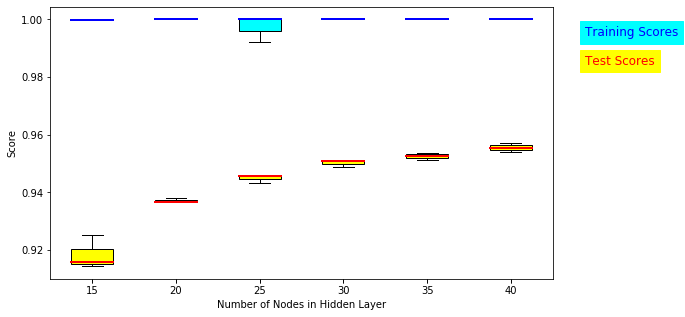

In [9]:
fig = plt.figure(figsize=(9, 5))
ax  = fig.add_subplot(111)

plot_train = ax.boxplot(train_scores_all,patch_artist=True)
plot_test  = ax.boxplot(test_scores_all,patch_artist=True)

plt.setp(plot_train['boxes'], facecolor='cyan')
plt.setp(plot_train['whiskers'], color='black')
plt.setp(plot_train['fliers'], color='red', marker='+')
for median in plot_train['medians']:  median.set(color='blue', linewidth=2)

plt.setp(plot_test['boxes'], facecolor='yellow')
for median in plot_test['medians']:  median.set(color='red', linewidth=2)

fig.text(0.95, 0.8, 'Training Scores', backgroundcolor='cyan', color='blue', weight='roman',size='large')
fig.text(0.95, 0.72, 'Test Scores', backgroundcolor='yellow', color='red', weight='roman',size='large')

ax.set_xlabel('Number of Nodes in Hidden Layer',fontsize = 10)
ax.set_ylabel('Score',fontsize = 10)

x_axis=[]
for n in n_nodes: x_axis.append(str(n))
ax.set_xticklabels(x_axis, fontsize = 10)

plt.show()

As it can be seen from the table above, the accuracy of the tests are really high even for the smallest single layer neural network and the accuracy saturates around 30 nodes. On the other hand, the training accuracy is ~100% from the start.

Now, let us do the optimization in a more automated way using Grid Search and look into a two layer neural network as well:

In [10]:
mlpc_grid    = MLPClassifier(solver = 'adam')
cv_type_grid = ShuffleSplit(n_splits= 5, test_size=0.25, random_state=42)
std_scaler   = preprocessing.StandardScaler()
pl_grid      = Pipeline(steps=[('std_scaler', std_scaler), ('mlpc_grid', mlpc_grid)])

hyper_params = {
    'mlpc_grid__hidden_layer_sizes': [(20,),(40,),(80,),(20,20),(40,40),(80,80)]
    ,'mlpc_grid__activation': ['tanh', 'relu'],
}

gridCV = GridSearchCV(pl_grid, hyper_params, n_jobs=-1, cv=cv_type_grid, return_train_score = True)
gridCV.fit(cv_data, cv_label)

test_means  = gridCV.cv_results_['mean_test_score']
test_stds   = gridCV.cv_results_['std_test_score']
fit_times   = gridCV.cv_results_['mean_fit_time']
params      = gridCV.cv_results_['params']

In [11]:
print("Test_mean  Test_sigma  Fit_time_mean(s)  Parameters")

for test_mean, test_std,fit_time, param in zip(test_means, test_stds, fit_times, params):
    print("%-11.4f %-11.3f %-15.2f %-11r" %(test_mean, test_std, fit_time, param))

print('\nBest model:', gridCV.best_params_)

Test_mean  Test_sigma  Fit_time_mean(s)  Parameters
0.9109      0.004       141.42          {'mlpc_grid__activation': 'tanh', 'mlpc_grid__hidden_layer_sizes': (20,)}
0.9345      0.002       90.85           {'mlpc_grid__activation': 'tanh', 'mlpc_grid__hidden_layer_sizes': (40,)}
0.9489      0.003       93.37           {'mlpc_grid__activation': 'tanh', 'mlpc_grid__hidden_layer_sizes': (80,)}
0.9162      0.004       110.05          {'mlpc_grid__activation': 'tanh', 'mlpc_grid__hidden_layer_sizes': (20, 20)}
0.9402      0.002       69.38           {'mlpc_grid__activation': 'tanh', 'mlpc_grid__hidden_layer_sizes': (40, 40)}
0.9525      0.002       75.32           {'mlpc_grid__activation': 'tanh', 'mlpc_grid__hidden_layer_sizes': (80, 80)}
0.9367      0.002       90.20           {'mlpc_grid__activation': 'relu', 'mlpc_grid__hidden_layer_sizes': (20,)}
0.9541      0.002       67.02           {'mlpc_grid__activation': 'relu', 'mlpc_grid__hidden_layer_sizes': (40,)}
0.9611      0.001       82.

The grid search results indicate: 
 * "relu" is performning slightly better than "tanh" as an activation function. 
 * accuracy of the NN is not improving much after 40 nodes, independent of number of layers in the model
 * run_time is decreasing significantly for multi-layer networks
 
To finalize our model, let us test the best model we encountered during grid search on the held out data:

In [13]:
final_mlpc= gridCV.best_estimator_
final_score = final_mlpc.score(held_out_data,held_out_label)
print("Score on held-out data: %.2f" %final_score)

Score on held-out data: 0.97


The results on the held-out data looks rather good, indicating that our model generalizes pretty well.